## University of Turin, September 2022
## Data Mining, Statistical Modeling and Machine Learning
# Bonaldo Federico n matricola 853475 

Reddit is an entertainment, social networking, and news website where registered community members can submit content, such as text posts or direct links, making it essentially an online bulletin board system. Registered users can then vote submissions up or down to organize the posts and determine their position on the site's pages. Content entries are organized by areas of interest called "subreddits". The subreddit topics include news, gaming, movies, music, books, fitness, food, and photosharing, among many others.

The scope of this competition is represent the **gender** of the users as binary classes: the class "**female**" is represented as **1** and the class "**male**" as **0**. The class prediction for each Reddit author corresponds to your confidence that the author is a female, which is a "score" computed for the author.

In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load the train data

In [2]:
train_data = pd.read_csv("train_data.csv", encoding="utf8")

In [3]:
train_data.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [4]:
train_data.author.unique().shape

(5000,)

In [5]:
target = pd.read_csv("train_target.csv")

In [6]:
target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


# Feature Extraction

In [7]:
subreddits = train_data.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0]))

In [8]:
from scipy import sparse

In [9]:
def extract_features(group):
    group_subreddits = group['subreddit']
    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values
    idxs = subreddits_map.loc[group_subreddits].values
    v = sparse.dok_matrix((1, subreddits.shape[0]))
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1
    return v.tocsr()

extract_features(train_data[train_data.author=='RedThunder90'])

<1x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [10]:
features_dict = {}

for author, group in train_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [11]:
X = sparse.vstack([features_dict[author] for author in target.author])
X

<5000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 49152 stored elements in Compressed Sparse Row format>

In [12]:
y = target.gender

In [13]:
def extract_text(group):
    group_text = group['body'].astype(str).values
    return " ".join(group_text)

extract_text(train_data[train_data.author=='RedThunder90'])

'I still prefer to buy foods either grown locally or where animals are treated better, but this definitely has me looking at organic food differently.'

In [14]:
text_dict = {}

for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)

In [15]:
author_text = [text_dict[author] for author in target.author]
author_text[0][:100]

'I still prefer to buy foods either grown locally or where animals are treated better, but this defin'

Data preparation:
at this step I split the dataset in several collections using the function train_test_split. This is useful because I can use some data as train and the rest as test from the starting dataset.

Then, I convert with term frequency inverse document frequency the text messages from Users by Reddit in matrix.

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split

pattern ='(?u)\\b[A-Za-z]{3,}'
tfidfv = TfidfVectorizer(token_pattern=pattern, stop_words=ENGLISH_STOP_WORDS, ngram_range=(1,1),max_features=20000)

X_train, X_test, y_train, y_test, author_text_train ,author_text_test = train_test_split(X, y,author_text, test_size = 0.1)

author_text_train = tfidfv.fit_transform(author_text_train)
author_text_test= tfidfv.transform(author_text_test)

In [17]:
X_train_FULL= sparse.hstack( (X_train,author_text_train ))
X_test_FULL= sparse.hstack( ( X_test, author_text_test ))

------------------------------------------------------------------------

# Model Selection:

## Multinomial Naive Bayes

**Testing the sub-reddit.**

We use now subreddit as training data. I'll use cross validation as resampling method and I'll test it for different **alpha value**, an hyperparameter used inside the Multinomial Naive Bayes model 

In [18]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(class_prior=[0.7,0.3])

In [19]:
alphas = np.logspace(-2, 2, 150)
alphas;

In [20]:
from sklearn import model_selection
from sklearn import metrics

scores=[]
training_score=[]
for alpha in alphas:
    clf.alpha = alpha
    clf.fit( X_train, y_train)
    training_score.append( clf.score( X_train, y_train ))
    s = model_selection.cross_val_score(clf, X_train, 
                                        y_train, cv=10)
    scores.append(s.mean())   

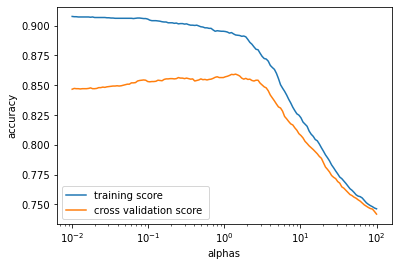

In [21]:
plt.plot( alphas, training_score, label='training score ')
plt.plot( alphas, scores, label= 'cross validation score ')
plt.xlabel('alphas')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend(loc='best')

In these two lines we can see the training score. It means the **In-sample-Error**. Cross validations is used for estimate the **Out-of-sample-Error**. 
Everything was calculated in a loop while alpha parameted was changing.

After that, I selected the **alpha** with the highest score and I'll test the model with test data.

In [22]:
best_alpha = alphas[np.argmax(scores)]
print('best alpha is ', best_alpha )
print( 'best score is' , max(scores) ) 

best alpha is  1.404918096835459
best score is 0.8593333333333334


In [23]:
clf= MultinomialNB( alpha=best_alpha, class_prior=[0.7,0.3])
clf.fit( X_train, y_train)
score= clf.score( X_test, y_test)
print('SCORE SUB-REDS', score)

SCORE SUB-REDS 0.848


**Testing the text.**


With an analogue proceed I'm using the text data to train the model during the TRAINING PHASE.
Then, I'll select the alpha with the most-likely generalization of the training data and I'll use it in the TEST PHASE. 


In [24]:
clf = MultinomialNB(class_prior=[0.7,0.3])
alphas= np.logspace(-2.5, 0.5, 100)
alphas;

In [25]:
scores = []
training_score=[]
for alpha in alphas:
    clf.alpha = alpha
    clf.fit(author_text_train, y_train)
    training_score.append( clf.score( author_text_train, y_train ))
    s = model_selection.cross_val_score(clf, author_text_train, 
                                        y_train, cv=10)
    scores.append(s.mean())

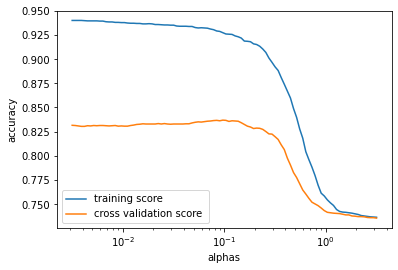

In [26]:
plt.plot( alphas, training_score, label='training score ')
plt.plot( alphas, scores, label= 'cross validation score ')
plt.xlabel('alphas')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend(loc='best')

Cross validation rappresents a good estimatior of the **Out-of-sample-error**

In [27]:
best_alpha = alphas[np.argmax(scores)]
print('best alpha is ', best_alpha )
print( 'best score is' , max(scores) ) 

best alpha is  0.09657139052966049
best score is 0.836888888888889


In [28]:
clf= MultinomialNB( alpha=best_alpha, class_prior=[0.7,0.3])
clf.fit( author_text_train , y_train)
score= clf.score( author_text_test, y_test)
print('SCORE SUB-REDS', score)

SCORE SUB-REDS 0.826


**Testing text+ subreddits.**

In this phase I'm putting together the data. I'm studying the entire dataset with text and subreddit together.

In [29]:
clf= MultinomialNB( class_prior=[0.7,0.3] )
scores = []
training_score=[]
alphas= np.logspace( -2, 1.0, 150)
alphas;

In [30]:
for alpha in alphas:
    clf.alpha = alpha
    clf.fit( X_train_FULL, y_train)
    training_score.append( clf.score( X_train_FULL, y_train ))
    s = model_selection.cross_val_score(clf, X_train_FULL, 
                                        y_train, cv=10)
    scores.append(s.mean())

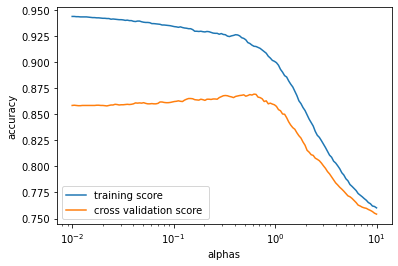

In [31]:
plt.plot( alphas, training_score, label='training score ')
plt.plot( alphas, scores, label= 'cross validation score ')
plt.xlabel('alphas')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend(loc='best')

In [32]:
best_alpha = alphas[np.argmax(scores)]
print('best alpha is ', best_alpha )
print( 'best score is' , max(scores) ) 

best alpha is  0.6193644990970611
best score is 0.8695555555555554


In [33]:
clf= MultinomialNB( alpha=best_alpha, class_prior=[0.7,0.3])
clf.fit( X_train_FULL, y_train)
score= clf.score( X_test_FULL, y_test)
print('SCORE SUB-REDS', score)

SCORE SUB-REDS 0.864


Putting together text and subreddits end into a little improvement in the generalization of the model.

---------------------------------------------------------

## Model selection: Multi Layer Perceptron
**Testing the sub-reddit** 

In this section I'm using Multi Layer Perceptron to analyse subreddit data.

In [1]:
from sklearn.neural_network import MLPClassifier

In [35]:
clf=MLPClassifier(max_iter=1500)
clf.fit( X_train, y_train )
score= clf.score( X_test, y_test)
print("Multilayer Perceptron, SUB-REDS ", score)

Multilayer Perceptron, SUB-REDS  0.818


In [2]:
MLPClassifier?


MLP has a good starting score. I want to find the best configuration for the hyperparameters to get the best accuracy.

Next step could take some minuts.

C:\Users\fbonn\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


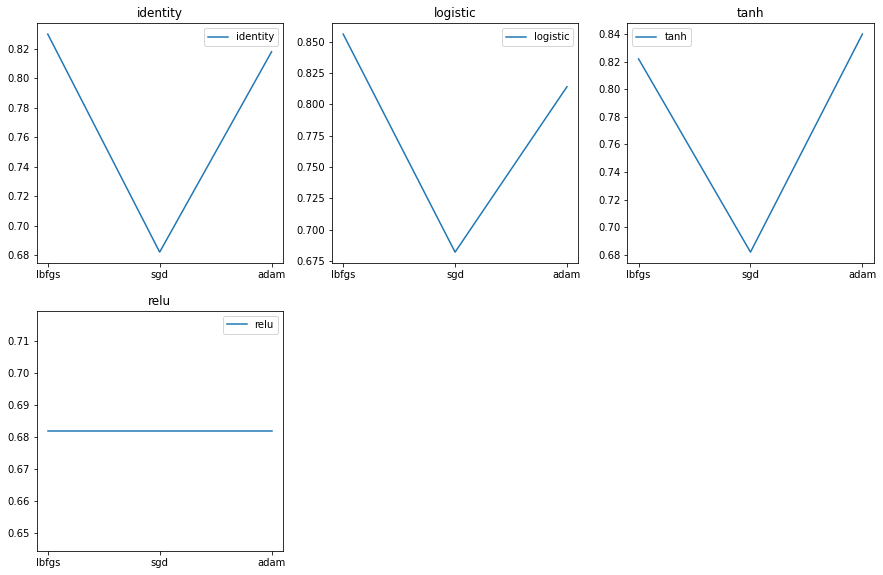

In [37]:
figure(figsize=(15,15))

i=0
functions=('identity', 'logistic', 'tanh', 'relu')
names=('lbfgs', 'sgd', 'adam')
score=[]

for function in functions:
    scores=[]
    i=i+1
    for name in names: 
        plt.subplot(3,3,i)
        clf= MLPClassifier( (4, 3, 2), max_iter=1000, activation= function, solver= name, learning_rate_init=0.01, learning_rate= 'invscaling')
        clf.fit(X_train, y_train)
        score.append( clf.score(X_test, y_test))
        scores.append( clf.score(X_test, y_test) )
    plt.plot( names, scores, label= function)
    plt.title( function )
    plt.legend(loc='best')

In [38]:
score;

In [39]:
clf=MLPClassifier( (4, 3, 2), max_iter=1000, activation= 'tanh', solver= 'adam', learning_rate_init=0.01, learning_rate= 'invscaling')
clf.fit( X_train, y_train )
score= clf.score(X_test, y_test )
print("Multilayer Perceptron, SUB-REDS ", score)

Multilayer Perceptron, SUB-REDS  0.824


In [40]:
alphas=np.logspace(-1.5,-1,6)
alphas;

MAX SCORE IS  0.826


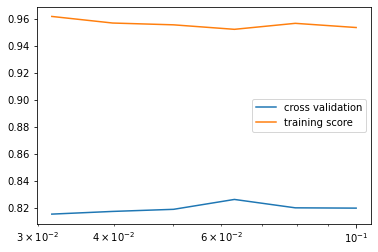

In [41]:
from sklearn import model_selection
from sklearn import metrics
scores=[]
training_scores=[]
clf=MLPClassifier( (4, 3, 2), max_iter=1000, activation= 'tanh', solver= 'adam', learning_rate_init=0.01, learning_rate= 'invscaling')

for alpha in alphas: 
    clf.alpha=alpha
    clf.fit(X_train, y_train)
    training_scores.append( clf.score(X_train, y_train))
    s=model_selection.cross_val_score( clf, X_train, y_train, cv=10)
    scores.append( s.mean())
    
plt.plot(alphas, scores, label= 'cross validation')
plt.plot( alphas, training_scores, label='training score')
plt.xscale('log')
plt.legend(loc='best')
print( 'MAX SCORE IS ' , max(scores))

In [42]:
best_alpha= alphas[argmax( scores)]
best_alpha

0.06309573444801933

In [43]:
print( 'MAX SCORE IS ' , max(scores))

MAX SCORE IS  0.826


In [44]:
clf=MLPClassifier( (4, 3, 2), max_iter=1000, activation= 'tanh', solver= 'adam', learning_rate_init=0.01, learning_rate= 'invscaling', alpha= best_alpha)
clf.fit( X_train, y_train )
score= clf.score( X_test, y_test)
print("Multilayer Perceptron, SUB-REDS ", score)

Multilayer Perceptron, SUB-REDS  0.846


**Testing the text** 

With the same method I will test the model with text data.

In [45]:
alphas= np.logspace(-1, 0.5, 10)
alphas;

MAX SCORE IS  0.8022222222222222


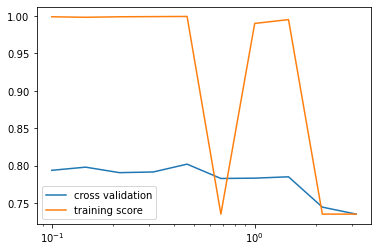

In [46]:
from sklearn import model_selection
from sklearn import metrics

scores=[]
training_scores=[]
clf=MLPClassifier( (4, 3, 2), max_iter=1000, activation= 'tanh', solver= 'adam', learning_rate_init=0.01, learning_rate= 'invscaling')

for alpha in alphas: 
    clf.alpha=alpha
    clf.fit(author_text_train, y_train)
    training_scores.append( clf.score(author_text_train, y_train))
    s=model_selection.cross_val_score( clf, author_text_train, y_train, cv=10)
    scores.append( s.mean())
    
plt.plot(alphas, scores, label= 'cross validation')
plt.plot( alphas, training_scores, label='training score')
plt.xscale('log')
plt.legend(loc='best')
print( 'MAX SCORE IS ' , max(scores))

In [47]:
best_alpha= alphas[argmax( scores)]
best_alpha

0.46415888336127786

In [48]:
print( 'MAX SCORE IS ' , max(scores))

MAX SCORE IS  0.8022222222222222


In [49]:
clf=MLPClassifier( (4, 3, 2), max_iter=1000, activation= 'tanh', solver= 'adam', learning_rate_init=0.01, learning_rate= 'invscaling', alpha= best_alpha)
clf.fit( author_text_train, y_train )
score= clf.score( author_text_test, y_test)
print("Multilayer Perceptron, SUB-REDS ", score)

Multilayer Perceptron, SUB-REDS  0.786


**testing text+sub-reddits**

In [50]:
alphas= np.logspace(-1, 0.5, 10)
alphas;

MAX SCORE IS  0.8488888888888887


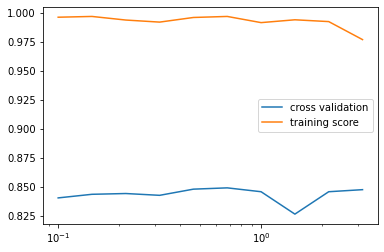

In [51]:
from sklearn import model_selection
from sklearn import metrics

scores=[]
training_scores=[]
clf=MLPClassifier( (4, 3, 2), max_iter=1000, activation= 'tanh', solver= 'adam', learning_rate_init=0.01, learning_rate= 'invscaling')

for alpha in alphas: 
    clf.alpha=alpha
    clf.fit(X_train_FULL, y_train)
    training_scores.append( clf.score(X_train_FULL, y_train))
    s=model_selection.cross_val_score( clf, X_train_FULL, y_train, cv=10)
    scores.append( s.mean())
    
plt.plot(alphas, scores, label= 'cross validation')
plt.plot( alphas, training_scores, label='training score')
plt.xscale('log')
plt.legend(loc='best')
print( 'MAX SCORE IS ' , max(scores))

In [52]:
best_alpha= alphas[argmax( scores)]
best_alpha

0.6812920690579611

In [53]:
print( 'MAX SCORE IS ' , max(scores))

MAX SCORE IS  0.8488888888888887


In [54]:
clf=MLPClassifier( (4, 3, 2), max_iter=1000, activation= 'tanh', solver= 'adam', learning_rate_init=0.01, learning_rate= 'invscaling', alpha= best_alpha)
clf.fit( X_train_FULL, y_train )
score= clf.score( X_test_FULL, y_test)
print("Multilayer Perceptron, SUB-REDS ", score)

Multilayer Perceptron, SUB-REDS  0.848


Multi Layer Perceptron has an high computational cost. The score we got is quite similar to the score by Multinomial NB.
Fothermore there wasn't a great improvement to the score after putting together text and subreddits.

---------------------------------------------------
## Model selection : Random Forest 

**testing the sub-reddits** . 

In this lines I'm trying Random Forest to train and test subreddits data.

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
trees=np.arange(100,300,5)

array([100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160,
       165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225,
       230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290,
       295])

In [56]:
scores=[]

for i in trees:
    clf=  RandomForestClassifier(criterion='entropy', n_estimators=i )
    clf.fit(X_train, y_train)
    #print( 'n tree: ',i, 'accuracy ',clf.score( X_test, y_test))
    scores.append( clf.score( X_test, y_test) )

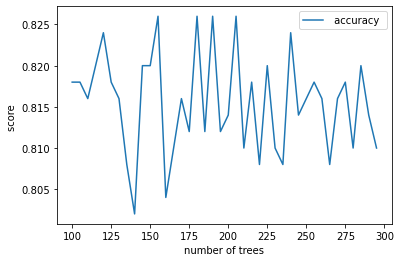

In [57]:
plt.plot( trees, scores , label=' accuracy ')
plt.xlabel('number of trees')
plt.ylabel( 'score ')
plt.legend( loc='best')

In [58]:
print( 'the best number of trees is ', trees[ argmax( scores)])

the best number of trees is  155


In [59]:
clf=  RandomForestClassifier(criterion='entropy', n_estimators=trees[ argmax( scores)])
clf.fit(X_train, y_train)
print( 'Random Forest score is  ',clf.score( X_test, y_test))

Random Forest score is   0.818


Results are not promising and encouraging. So we skip to another model. 

----------------------------------------------------------------------
## Model selection : Logistic Regression

Logistic Regression is the easiest model to study this dataset. I'm studying its behaviour with subreddits, text, and subreddits + text. 

**testing the sub-reddits**

In [60]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(X_train, y_train)
print( 'Logistic Regression score is ', clf.score( X_test, y_test))

Logistic Regression score is  0.876


**testing the text**

In [61]:
clf=LogisticRegression()
clf.fit(author_text_train, y_train)
print( 'Logistic Regression score is ',clf.score( author_text_test, y_test))

Logistic Regression score is  0.792


**testing sub-reddits + text** 

In [62]:
clf=LogisticRegression()
clf.fit(X_train_FULL, y_train)
print( 'Logistic Regression score is ', clf.score( X_test_FULL, y_test))

Logistic Regression score is  0.88


In [63]:
LogisticRegression?

----------------------------------------------------
## Final Model 
## Testing the Multinomial NB 

As final model I choose Nultinomial NB.

If we compare **Multi-layer Perceptron** and **Multinomial NB**, the latter is better because the scores are not so different but the computational cost are so different. The Former has a higher computational cost and its causes a slower execution. That could be faster i.g. reducing the max number of total iterations but it will compromise its performance. 

If we compare **Logistic Regression** and **Multinomial NB** I choose the latter. These two models have similar results and scores on the training data. This is caused because MNB inherited by Logistic Regression. But, MNB is a **generative model** i.e. this model works modelling the posterior probability by the output of prior probability and Likelyhood.

Logistic Regression is a discriminative model i.e. it reads only the training data and not the prior probability to get an class instead the other.


--------------------------------------------

I'm going to test Multinomial NB with an higher statistics i.e. with the entire dataset. This is because MNB asks a great number of points.

I'm applying term-frequency inverse doc-frequency to the author_text data. I'll study text+ subreddits. Then I'll use cross validation vs training score and I'll study the best alpha of the model.

In the end, I'll use the best alpha to test the model to the dataset it has not never seen and lerned. 

In [64]:
tfidfv = TfidfVectorizer(token_pattern=pattern, stop_words=ENGLISH_STOP_WORDS, ngram_range=(1,1), max_features=20000)
X_text_train = tfidfv.fit_transform(author_text)

In [65]:
X_train = sparse.hstack( ( X, X_text_train ))

In [66]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(class_prior=[0.7,0.3])

In [67]:
alphas = np.logspace(-2, 2, 150)
alphas;

In [68]:
from sklearn import model_selection
from sklearn import metrics

scores=[]
training_score=[]
for alpha in alphas:
    clf.alpha = alpha
    clf.fit( X_train, y)
    training_score.append( clf.score( X_train, y ))
    s = model_selection.cross_val_score(clf, X_train, 
                                        y, cv=10)
    scores.append(s.mean())   

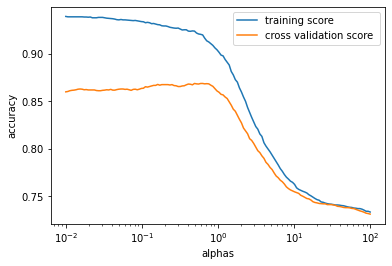

In [69]:
plt.plot( alphas, training_score, label='training score ')
plt.plot( alphas, scores, label= 'cross validation score ')
plt.xlabel('alphas')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend(loc='best')

In [70]:
best_alpha= alphas[argmax( scores)]
best_alpha

0.6290102436234459

In [71]:
print( 'MAX SCORE IS ' , max(scores))

MAX SCORE IS  0.8686000000000001


In [72]:
clf= MultinomialNB( alpha=best_alpha, class_prior=[0.7,0.3])
clf.fit( X_train, y)
score= clf.score( X_train, y)
print('SCORE SUB-REDS', score)

SCORE SUB-REDS 0.9196


Acting in this way we test only with training data and not with testing data. **Out-of-sample-Error** could be valued with the graph above with the cross validation score line.

# Prepare the solution

In [73]:
test_data = pd.read_csv("test_data.csv", encoding="utf8")

In [74]:
features_dict = {}

for author, group in test_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [75]:
X_test = sparse.vstack([features_dict[author] for author in test_data.author.unique()])
X_test

<15000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 144898 stored elements in Compressed Sparse Row format>

In [76]:
text_dict = {}

for author, group in test_data.groupby('author'):
    text_dict[author] = extract_text(group)

In [77]:
author_text_test = [text_dict[author] for author in test_data.author.unique()]

In [78]:
author_text_test[0][:100]

"I hadn't ever heard of them before joining this subreddit. They're not really a big thing in the US,"

In [79]:
author_text_test= tfidfv.transform(author_text_test)

In [80]:
X_TEST= sparse.hstack( ( X_test, author_text_test ))

In [81]:
y_pred = clf.predict_proba(X_TEST)[:,1]

In [82]:
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":y_pred})
solution.head()

,author,gender
0,ejchristian86,1.000000e+00
1,ZenDragon,1.195906e-12
2,savoytruffle,3.497827e-05
3,hentercenter,1.876872e-04
4,rick-o-suave,7.195420e-02


In [83]:
solution.to_csv("Mysolution.csv", index=False)

## Conclusion


This notebook was written for the exam "Data Mining, Statistical Modeling and Machine Learning" in Physics of Complex System in University of Turin in September 2022.

This notebook represented half part of the exam. To pass it you must prepare this notebook and sign in a internal competition in Kaggle. After the registration to the competition, you load the .csv to the exam's page and valued your results with the "correct" results provided by professors.

The **Roc accuracy** of my results was **0.91804**.

I'm so satisfied about this result and the result of my exam. It was so good and I received so many congratulations from my professors. I found this task very interesting, and it made me curious about this field. I'm so glad to have chosen this exam on my CV.

Thanks for the attention.

Federico Bonaldo
